# Outlier detection

For every data analysis project, it is very important to identify the outliers in the data.
Although some algorithms are designed to be robust aginst outliers (robust statistics), generally better results can be obtained by using the regular algos with outliers-removed dataset. 

Why don’t we use robust measures all the time?  Well,  we pay the price for robustness by compromisingthe efficiency 
(no-free-lunch theorem).  An estimate is "efficient" if it has small variability or standard error. So, robustness and efficiency are competing  factors. For  example,  median  has  larger  SE  than  the mean.

Some algorithms are less sensitive to outliers. SVM, for example, just needs the information of the support vector of the decision boundary which are data points in its 'immediate' neighborhood. Even in such cases outliers pose difficulties for 
the numerical computations.

There are many ways to adjudicate that a datum is outlier or not and it always depends on your data. Domain experties would also help as some times data points that appear to be outlier are infact meaningful events (ozon data)!

In this notebook, I go through some methods of identifying and removing the outliers from the dataset.

By: Mehdi Paak

In [379]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import scipy 

# Utility functions

In [367]:
def FindOutliersNormal(data, K=3, Plot=False):
    """ 
    Find outliers based on z-score and
    assuming data is normal.
    
    data: pd.Series
    K: threshold |z| > K is outlier
    """
    mu = data.mean()
    std = data.std()
    Zs = (data - mu)/std
    Outliers = data[np.abs(Zs) > K]

    if(Plot):
        PlotUtilNormal(data, Outliers)
        
    return Outliers.index, Outliers.values


In [386]:
def PlotUtilNormal(data,Outliers):
    """
    Plots distribution and outliers
    data: pd.Series
    Outliers: pd.Series
    
    Note: requires seaborn, pyplot
    """
    data.sort_values(inplace=True)
    plt.figure()
    ax1 = plt.subplot()
    sns.distplot(data, hist=True, kde=True, 
                 color = 'darkblue', 
                 hist_kws={'edgecolor':'black'},
                 kde_kws={'linewidth': 1}, ax=ax1, label='distribution');
    ax1.plot(data.values, PdfNorm(data), 'r--', linewidth=1, label='Pdf Normal')
    
    ax1.plot(Outliers.values,np.ones(len(Outliers))*0.01, 'rx', markeredgewidth=2,label='outliers' )
    
    ax1.set_xlabel('data')
    ax1.set_ylabel('pdf')
    ax1.legend()
    

In [369]:
def PdfNorm(data):
    """
    PDF of Gaussian distribution.
    data: pd.Series
    """
    mu = data.mean()
    sig = data.std()+1.0e-15
    pdf = lambda x: (1/(np.sqrt(2*np.pi)*sig))*np.exp(-0.5*((x-mu)/sig)**2)
    return pdf(data.values)

In [370]:
def FindOutliersIQR(data, K=1.5, Plot=False):
    """ 
    Find outliers based on Tukey IQR
    IQR = Q3-Q1
    Outliers are not in [Q1 - K*IQR, Q3 + K*IQR]
    
    data: pd.Series
    K: threshold. 1.5 standard, 3 extreme 
    """    
    Percentile = [25,75] # Q1 and Q3 in %
    Q1,Q3 = np.percentile(data,Percentile)
    IQR = Q3-Q1
    Outliers = data[(data < (Q1-K*IQR)) | (data > (Q3+K*IQR))]
    
    if(Plot):
        PlotUtilIQR(data, Outliers)
    
    return Outliers.index, Outliers.values
    

In [408]:
def PlotUtilIQR(data,Outliers):
    """
    Plots distribution and outliers 
    data: pd.Series
    Outliers: pd.Series
    
    Note: requires seaborn, pyplot
    """
    plt.figure()
    grid = plt.GridSpec(3,1, hspace=0.0)
    ax_hist = plt.subplot(grid[0:2,:])
    ax_box = plt.subplot(grid[2,:], sharex=ax_hist)

    sns.distplot(data, hist=True, kde=True, 
                 color = 'darkblue', 
                 hist_kws={'edgecolor':'black'},
                 kde_kws={'linewidth': 2}, ax=ax_hist, label='distribution');

    ax_hist.plot(Outliers.values,np.ones(len(Outliers))*0.05, 'rx', markeredgewidth=2,label='Outliers' )
    ax_hist.legend()

    sns.boxplot(data,ax=ax_box)
    
    ax_box.set_xlabel('data')
    ax_hist.set_ylabel('pdf')
    ax_hist.legend()

In [418]:
def FindOutliersKDE(data, K=0.01, Plot=False):
    """
    Find outliers based on kernel density estimation (kde)
    data: pd.Series
    K: threshold, here the probability sensity of observing the data
    
    Note: requires statsmodels (statsmodels.nonparametric.KDEUnivariate)
    """
    kde = sm.nonparametric.KDEUnivariate(data)
    kde.fit(bw='scott', fft=True)
    pdf = kde.evaluate(data.values)    
    
    pred= (pdf < K)
    Outliers = data[pred]
    
    if(Plot):
        PlotUtilKDE(data, Outliers)
    
    return Outliers.index, Outliers.values    

In [377]:
def PlotUtilKDE(data,Outliers):
    """
    Plots distribution and outliers
    data: pd.Series
    Outliers: pd.Series
    
    Note: requires seaborn, pyplot
    """
    plt.figure()
    ax1=plt.subplot()
    sns.distplot(data, hist=True, kde=True, norm_hist=True, color = 'darkblue', hist_kws={'edgecolor':'black'},
                 kde_kws={'linewidth': 2}, ax=ax1, label='data distribution');
    
    ax1.plot(Outliers.values,np.ones(len(Outliers))*0.01, 'rx', markeredgewidth=2, label='Outliers')

    ax1.set_xlabel('data')
    ax1.set_ylabel('pdf')
    ax1.legend()

# Normally distributed data

$data \sim N(\mu,\sigma^2)$

In [27]:
# lets create a sample from normal distribution
np.random.seed(113)
SizeData = 1000
mu = 1
std= 2
data_N = pd.Series(mu+std*np.random.randn(SizeData))

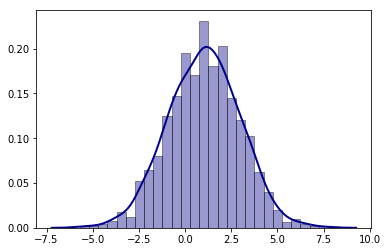

In [128]:
plt.figure()
ax1 = plt.subplot()
sns.distplot(data_N, hist=True, kde=True, 
             color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2}, ax=ax1);

Let's look at the stats, should be close to normal

In [29]:
data_N.describe()

count    1000.000000
mean        1.019282
std         1.927141
min        -5.701958
25%        -0.269055
50%         1.053444
75%         2.298134
max         7.731814
dtype: float64

## Find outlier points

Ok, this is subjective. Assuming data is normal, for one application data points 3 standard deviation ($3 \sigma$) away from the mean are outliers for some other may be $2.5\sigma$. In general, $3 \sigma$ is a reasonable value as the probability 
of observing data in that distance is less than 1%.


In [74]:
Outliers = data_N[(data_N > (3* data_N.std()+data_N.mean())) | (data_N < (-3* data_N.std()+data_N.mean()))]

In [75]:
Outliers

143   -5.134290
222    7.731814
654   -5.701958
818    6.811061
dtype: float64

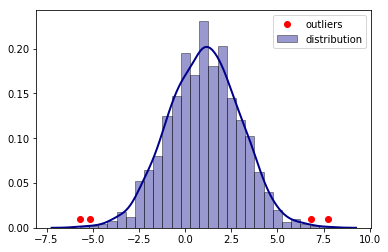

In [127]:
plt.figure()
ax1 = plt.subplot()
sns.distplot(data_N, hist=True, kde=True, 
             color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2}, ax=ax1, label='distribution');
ax1.plot(Outliers,np.ones(len(Outliers))*0.01, 'ro',label='outliers' )
ax1.legend()

In general, calculate the z-score of the data (assuming normally distributed): $z_i=\frac{x_i-\bar{x}}{\sigma}$ where $x_i$ are
the data points. 

$$Outliers\; Indecies =  \{i * I(|z_i| > 3)\} \;\; i=1,\ldots, N$$

In [65]:
FindOutliersNormal(data_N,3) # function to find outliers based on normality assumption

(Int64Index([143, 222, 654, 818], dtype='int64'),
 array([-5.13429014,  7.73181445, -5.70195824,  6.81106146]))

# No assumption on distribution

Often times data are not normally distributed. Note that central limit theorem holds for the "mean" of iid samples.
Many datasets show skewness (e.g. income data). For such cases, using normality for outlier detection does not yield 
good results. Instead, it is recommended to take where most data exist as "in-liers" and those way far from the rest of the 
society as outliers. One way of implementing this idea is the Tukey IQR method:

$$Q_1,Q_2, Q_3 = icdf(25\%), icdf(20\%), icdf(75\%)$$

$$IQR = Q_3-Q_1$$

$$non outliers \in [Q_1-k\times IQR, Q_3+k\times IQR]$$

where $k$ is usualy taken to be $1.5$

In [396]:
# create a skewed data set
np.random.seed(113)
Skw_Param = 8;
data_sk = pd.Series(scipy.stats.skewnorm.rvs(Skw_Param, size=1000))

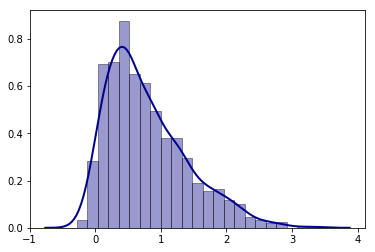

In [397]:
# look at the data distribution
plt.figure()
sns.distplot(data_sk, hist=True, kde=True, 
             color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},  label='skewed distribution');

In [398]:
# stats
data_sk.describe()

count    1000.000000
mean        0.790891
std         0.611739
min        -0.278012
25%         0.328505
50%         0.641448
75%         1.144992
max         3.396492
dtype: float64

Let's get weicked and try to find the outliers of the skewed dataset using the normal data assumption. I use the function here:

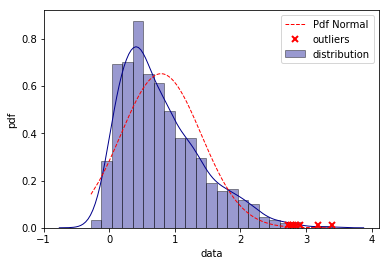

In [399]:
OutliersN_indx, OutliersN_val = FindOutliersNormal(data_sk,K=3,Plot=True)

## Tukey IQR

The Tukey IQR is implemented in the function FindOutliersIQR. In the following, I compare the results from this 
mehtod and those from FindOutliersNormal.

In [400]:
Outliers_indx, Outliers_val = FindOutliersIQR(data_sk,1.5);

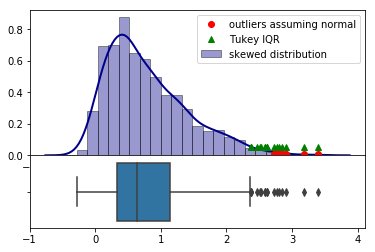

In [401]:
plt.figure()
grid = plt.GridSpec(3,1, hspace=0.0)
ax_hist = plt.subplot(grid[0:2,:])
ax_box = plt.subplot(grid[2,:], sharex=ax_hist)

sns.distplot(data_sk, hist=True, kde=True, 
             color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2}, ax=ax_hist, label='skewed distribution');
ax_hist.plot(OutliersN_val,np.ones(len(OutliersN_val))*0.01, 'ro',label='outliers assuming normal' )
ax_hist.plot(Outliers_val,np.ones(len(Outliers_val))*0.05, 'g^',label='Tukey IQR' )
ax_hist.legend()

sns.boxplot(data_sk,ax=ax_box);



It is seen that the Tukey method identifies more points as outliers. 

# Kernel density estimation (KDE), Non-parametric 

What if the data is bimodal. Let's create a bimodal distribution.
KDE is a nonparametric way to estimate the pdf of a data set. By nonparametric we mean no assumptions is made
about the shape and characteristics of the underlying distribution. Note that in KDE, there exist a bandwidth parameter
which needs to be chosen carefully to get the desired response. There are methods developped for choosing a good value (e.g. scott or silverman methods).

In [403]:
# create bimodal data and add two outliers points in addition to what already exist in the data
np.random.seed(113)
loc1, scale1, size1 = (-3, 1.5, 500)
loc2, scale2, size2 = (2.5, 0.5, 500)
data_bm = np.concatenate([np.random.normal(loc=loc1, scale=scale1, size=size1),
                      np.random.normal(loc=loc2, scale=scale2, size=size2)])
BadData = np.array([1.5*data_bm.min(), 1.5*data_bm.max()]) # contrive and add two outlier points
print("Bad data: ", BadData)
data_bm = np.concatenate((data_bm, BadData))
data_bm = pd.Series(data_bm)
data_bm.sort_values(inplace=True)

Bad data:  [-10.62835634   6.26570969]


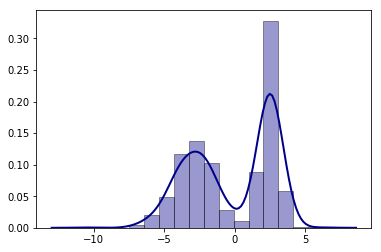

In [404]:
# That's how data looks like
plt.figure()
ax1=plt.subplot()
sns.distplot(data_bm, hist=True, kde=True, color = 'darkblue', hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2}, ax=ax1, label='bimodal distribution');


In [405]:
# stats fail to accurately describe multimodal data
data_bm.describe()

count    1002.000000
mean       -0.187107
std         2.936589
min       -10.628356
25%        -2.829374
50%         1.191027
75%         2.520022
max         6.265710
dtype: float64

Again, I first try outlier detection using FindOutliersNormal:

(Int64Index([1000], dtype='int64'), array([-10.62835634]))

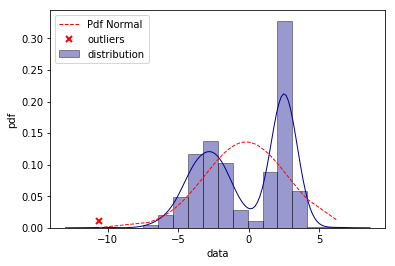

In [406]:
FindOutliersNormal(data_bm, Plot=True)

Just one point detected!

 Find outliers using Tukey IQR

(Int64Index([], dtype='int64'), array([], dtype=float64))

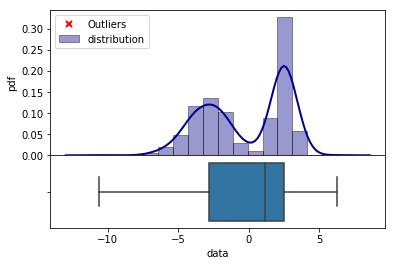

In [409]:
FindOutliersIQR(data_bm, Plot=True)

## KDE method

In the kernel density estimation (KDE) method, a kernel (often Gaussian) is used to estimate the pdf of the data.
Once the pdf is calculated it can be used to find the data points which are in the lowset and highest 1% or 5% (threshold) probability tails and tag them as outliers.

In [410]:
kde_bm = sm.nonparametric.KDEUnivariate(data_bm)

In [411]:
kde_bm.fit(bw='scott', fft=True)
pdf_bm = kde_bm.evaluate(data_bm.values)

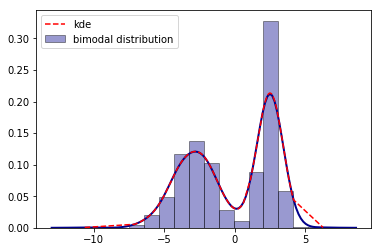

In [412]:
plt.figure()
ax1=plt.subplot()
sns.distplot(data_bm, hist=True, kde=True,norm_hist=True, color = 'darkblue', hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2}, ax=ax1, label='bimodal distribution');
ax1.plot(data_bm.values,pdf_bm,'r--', label='kde');
ax1.legend()

In [413]:
pred=(pdf_bm <0.01) # use 1% as the probability (density) threshold to find data at extremes

In [414]:
data_bm[pred]

1000   -10.628356
490     -7.085571
147     -6.864239
103     -6.770290
24      -6.737678
1001     6.265710
dtype: float64

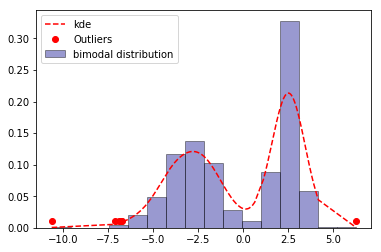

In [416]:
plt.figure()
ax1=plt.subplot()
sns.distplot(data_bm, hist=True, kde=False,norm_hist=True, color = 'darkblue', hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2}, ax=ax1, label='bimodal distribution');
ax1.plot(data_bm.values,pdf_bm,'r--', label='kde');
ax1.plot(data_bm[pred],np.ones(len(data_bm[pred]))*0.01, 'ro', label='Outliers')
ax1.legend()

In [419]:
FindOutliersKDE(data_bm,0.01)

(Int64Index([1000, 490, 147, 103, 24, 1001], dtype='int64'),
 array([-10.62835634,  -7.08557089,  -6.86423936,  -6.77029021,
         -6.73767848,   6.26570969]))

# Conclusion

Three methods of outlier detection have been explained:

- Using z-score assuming data is normally distributed
- Using Tukey IQR method
- Using kernel density estimation

Outlier detection and removal should be part of the ML/visualization pipeline.
Caveate: data identified as outliers may not be "outlier" in the true sense; they may carry important information.
Use your expert judgment.

(Int64Index([0, 1, 998, 999], dtype='int64'),
 array([-5.70195824, -5.13429014,  6.81106146,  7.73181445]))

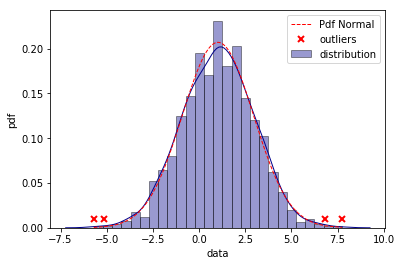

In [420]:
FindOutliersNormal(data_N,K = 3,Plot=True)

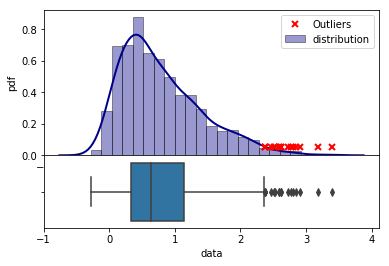

In [421]:
FindOutliersIQR(data_sk, K=1.5,Plot=True);

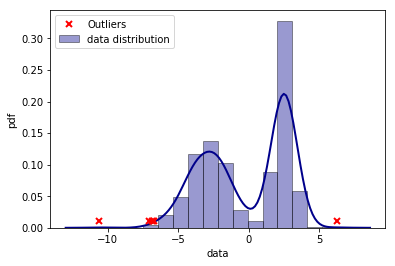

In [422]:
FindOutliersKDE(data_bm, K= 0.01, Plot=True);